In [1]:
import torch
from torch import nn
from torch import optim
import torchsummary
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
# Default Split
train_data = torchvision.datasets.MNIST(
    root='./data/mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = torchvision.datasets.MNIST(
    root='./data/mnist/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [3]:
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [4]:
train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=128,
    num_workers=0,
    # pin_memory=True,
    # pin_memory_device='cuda:1'
    # shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=len(test_data),
    num_workers=0,
    # pin_memory=True,
    # pin_memory_device='cuda:0',
    # shuffle=False
)

In [5]:
class MNISTV0(nn.Module):
    def __init__(self) -> None:
        super(MNISTV0, self).__init__()
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2,2), stride=2),
        )
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(1,1)),
        )
        self.cnn_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2,2), stride=2),
        )
        self.cnn_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(1,1)),
        )
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(10*26*26, 10),
        )
    
    def forward(self, x):
        x = self.cnn_block_1(x)
        x = self.cnn_block_2(x)
        x = self.cnn_block_3(x)
        x = self.cnn_block_4(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [6]:
model = MNISTV0()
model.to('cuda:0')

MNISTV0(
  (cnn_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (cnn_block_4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Sequential(
    (0): Linear(in_features=6760, out_features=10, bias=True)
  )
)

In [7]:
# torchsummary.summary(model, input_size=(1, 28, 28), device='cuda:1')

In [8]:
import torchinfo
torchinfo.summary(model, input_size=(32, 1, 28, 28))

ModuleNotFoundError: No module named 'torchinfo'

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 3

for epoch in tqdm(range(EPOCHS), total=EPOCHS, desc='Epoch', unit='epoch', colour='green'):
    # Train
    model.train()
    for batch_idx, (data, label) in enumerate(train_data_loader):
        data, label = data.to('cuda:1'), label.to('cuda:1')
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
    # Test
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        correct = 0
        for data, label in test_data_loader:
            data, label = data.to('cuda:1'), label.to('cuda:1')
            output = model(data)
            test_loss += loss_fn(output, label).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(label.view_as(pred)).sum().item()
            
        test_loss /= len(test_data_loader)
    
    print(f'Epoch: {epoch}, Test Loss: {test_loss}, Test Set Accuracy: {correct/len(test_data_loader.dataset)}')
        

Epoch:  33%|███▎      | 1/3 [00:08<00:17,  8.70s/epoch]

Epoch: 0, Test Loss: 0.14213719964027405, Test Set Accuracy: 0.9578


Epoch:  67%|██████▋   | 2/3 [00:16<00:08,  8.10s/epoch]

Epoch: 1, Test Loss: 0.07230076193809509, Test Set Accuracy: 0.9775


Epoch: 100%|██████████| 3/3 [00:24<00:00,  8.07s/epoch]

Epoch: 2, Test Loss: 0.06685061007738113, Test Set Accuracy: 0.9782


In [ ]:
torch.save(model, './model/mnist_v1.pth')

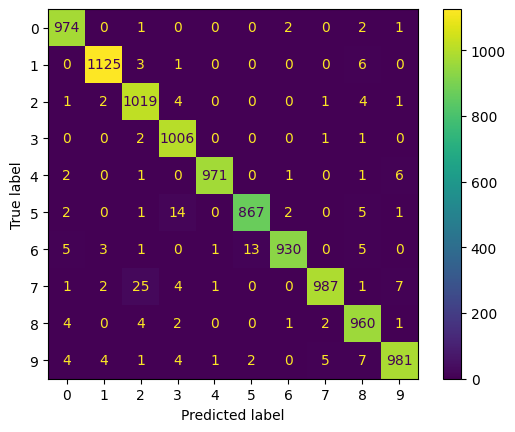

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.inference_mode():
    predictions = []
    test_data_labels = []
    test_data_images = []
    for data, label in test_data_loader:
        test_data_images += data.tolist()
        data = data.to('cuda:1')
        output = model(data)
        pred = output.argmax(dim=1)
        predictions += pred.tolist()
        test_data_labels += label.tolist()

cm = confusion_matrix(test_data_labels, predictions, labels=[i for i in range(10)])
ConfusionMatrixDisplay(cm).plot()

Total Wrong Predictions 180/10000 | Accuracy: 0.982


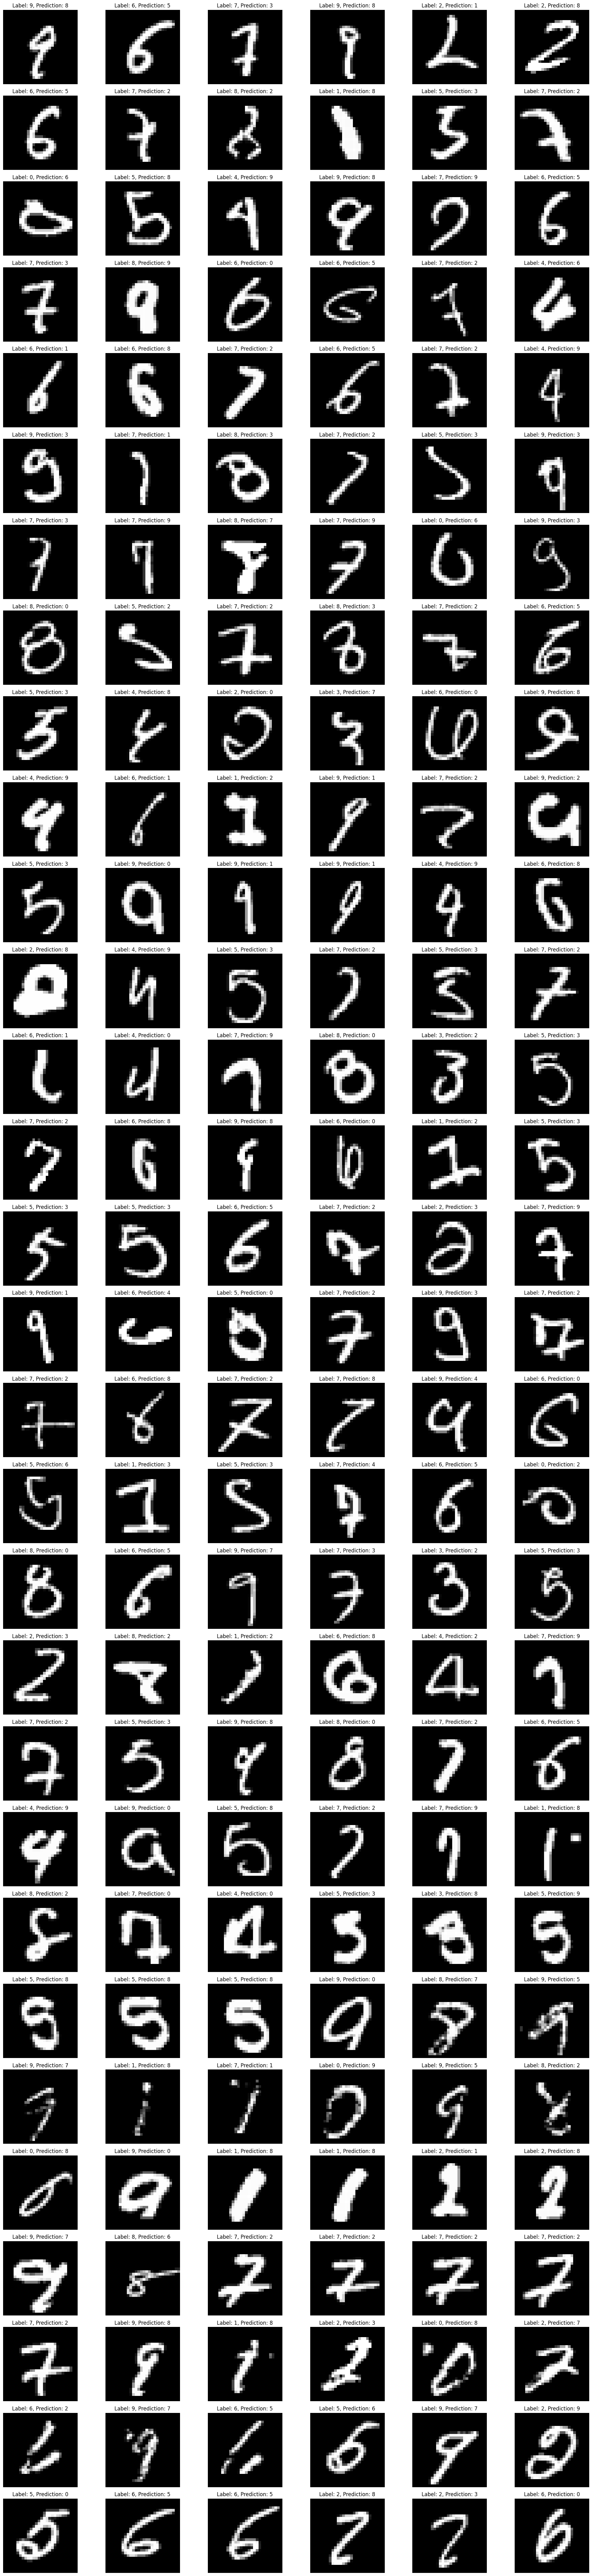

In [ ]:
from matplotlib import pyplot as plt

wrong_predictions_indices = [i for i in range(len(test_data_labels)) if test_data_labels[i] != predictions[i]]

nrows, ncols = len(wrong_predictions_indices)//5, 6

plt.figure(figsize=(20, 100))

for index, i in zip(wrong_predictions_indices, range(len(wrong_predictions_indices))):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(test_data_images[index][0], cmap='gray')
    plt.title(f'Label: {test_data_labels[index]}, Prediction: {predictions[index]}')
    plt.axis('off')

print(f'Total Wrong Predictions {len(wrong_predictions_indices)}/{len(test_data_labels)} | Accuracy: {1-len(wrong_predictions_indices)/len(test_data_labels)}')

plt.tight_layout()
plt.show()